## **Deep Q-Network for Resource Scaling**
**A DQN agent is used to decide whether to scale up, scale down, or take no action.**

1. Import libraries

In [31]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
from sklearn.metrics import mean_absolute_error, mean_squared_error

2. Define RL environment

In [32]:
#Define the RL Environment using CSV datasets with a fixed reward function.
class ResourceScalingEnvCSV:
    def __init__(self, ec2_file="reduced_ec2_data.csv", 
                 rds_file="reduced_rds_data.csv", 
                 ecs_file="reduced_ecs_data.csv"):
        # Load CSV files and select the appropriate CPU utilization column,
        # converting values to floats and filling missing values with 0.
        self.ec2_data = pd.read_csv(ec2_file)["EC2_CPUUtilization"].apply(pd.to_numeric, errors='coerce').fillna(0).values
        self.rds_data = pd.read_csv(rds_file)["RDS_CPUUtilization"].apply(pd.to_numeric, errors='coerce').fillna(0).values
        self.ecs_data = pd.read_csv(ecs_file)["ECS_CPUUtilization"].apply(pd.to_numeric, errors='coerce').fillna(0).values

        # Use the shortest dataset length for a consistent episode length.
        self.length = min(len(self.ec2_data), len(self.rds_data), len(self.ecs_data))
        self.state_size = 3  # one value per service
        self.action_size = 3  # 0: scale up, 1: scale down, 2: no action
        # Set target utilization lower than the typical base value (e.g., 0.4)
        self.target = np.array([0.4, 0.4, 0.4])
        self.index = 0
        self.effect = np.zeros(self.state_size)
    
    def reset(self):
        self.index = 0
        self.effect = np.zeros(self.state_size)
        base_state = np.array([self.ec2_data[self.index], 
                               self.rds_data[self.index], 
                               self.ecs_data[self.index]])
        state = np.clip(base_state + self.effect, 0, 1)
        return state
    
    def step(self, action):
        # Modify the effect based on action:
        # Scale Up (action 0): reduces effective utilization (subtract 0.1)
        # Scale Down (action 1): increases effective utilization (add 0.1)
        # No Action (action 2): leaves effect unchanged.
        if action == 0:
            self.effect -= 0.1
        elif action == 1:
            self.effect += 0.1

        self.index += 1
        done = False
        if self.index >= self.length:
            done = True
            self.index = self.length - 1  # Clamp to last index
        
        base_state = np.array([self.ec2_data[self.index], 
                               self.rds_data[self.index], 
                               self.ecs_data[self.index]])
        state = np.clip(base_state + self.effect, 0, 1)
        # Compute reward as negative average absolute error from the target, scaled by 3.
        reward = -3 * np.mean(np.abs(state - self.target))
        return state, reward, done

3. Defining DQN

In [33]:
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, action_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

4. Define the DQN Agent with a target network and gradient clipping

In [34]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=5000)
        self.gamma = 0.98          # discount factor
        self.epsilon = 1.0         # exploration rate
        self.epsilon_min = 0.001
        self.epsilon_decay = 0.998
        self.learning_rate = 0.0003  # lowered learning rate
        self.model = DQN(state_size, action_size)
        # Create a target network and initialize it with the same weights.
        self.target_model = DQN(state_size, action_size)
        self.update_target_model()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()
    
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.choice(range(self.action_size))
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action_values = self.model(state_tensor)
        return torch.argmax(action_values).item()
    
    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
            target = reward
            if not done:
                # Use the target network for a more stable target calculation.
                target = reward + self.gamma * torch.max(self.target_model(next_state_tensor)).item()
            predicted = self.model(state_tensor)[0][action]
            loss = self.criterion(predicted, torch.tensor(target).float())
            self.optimizer.zero_grad()
            loss.backward()
            # Clip gradients to stabilize training.
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

5. Main Training Loop 

In [35]:
def train_rl_agent(episodes=2000):
    env = ResourceScalingEnvCSV()
    agent = DQNAgent(env.state_size, env.action_size)
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        step = 0
        done = False
        while not done and step < env.length:
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            step += 1
        agent.replay(64)
        # Update target network every 25 episodes.
        if (episode + 1) % 25 == 0:
            agent.update_target_model()
        avg_reward = total_reward / step  # average reward per step
        if (episode+1) % 50 == 0:
            print(f"Episode {episode+1}/{episodes}, Avg Reward per Step: {avg_reward:.4f}, Epsilon: {agent.epsilon:.4f}")
    torch.save(agent.model.state_dict(), "dqn_scaling_model.pth")
    print("DQN model saved!")

6. Evaluate the Trained RL Agent

In [36]:
def evaluate_rl_agent(episodes=100):
    env = ResourceScalingEnvCSV()
    agent = DQNAgent(env.state_size, env.action_size)
    agent.model.load_state_dict(torch.load("dqn_scaling_model.pth"))
    agent.model.eval()
    
    total_rewards = []
    action_counts = {0: 0, 1: 0, 2: 0}
    
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        step = 0
        done = False
        while not done and step < env.length:
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            total_reward += reward
            action_counts[action] += 1
            state = next_state
            step += 1
        avg_reward = total_reward / step
        total_rewards.append(avg_reward)
    
    overall_avg = np.mean(total_rewards)
    action_distribution = {k: v / sum(action_counts.values()) for k, v in action_counts.items()}
    
    mae = mean_absolute_error(total_rewards, np.zeros_like(total_rewards))
    mse = mean_squared_error(total_rewards, np.zeros_like(total_rewards))
    rmse = np.sqrt(mse)
    
    print(f"Average Reward per Step over evaluation episodes: {overall_avg:.4f}")
    print(f"Action Distribution: {action_distribution}")
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}")
    
    return overall_avg, action_distribution, mae, mse, rmse



7. Run training and evaluation

In [37]:

if __name__ == "__main__":
    train_rl_agent()
    evaluate_rl_agent()

FileNotFoundError: [Errno 2] No such file or directory: 'reduced_ec2_data.csv'

Testing

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
from sklearn.metrics import mean_absolute_error, mean_squared_error
import gym
from gym import spaces

# 1. Updated Environment Class with Modified Reward Function
class ResourceScalingEnvCSV:
    def __init__(self, ec2_file="../reduced_ec2_data.csv", 
                 rds_file="../reduced_rds_data.csv", 
                 ecs_file="../reduced_ecs_data.csv"):
        # Load CSV files and select the appropriate CPU utilization column.
        # Convert values to float and fill missing values with the column's mean.
        df_ec2 = pd.read_csv(ec2_file)
        self.ec2_data = pd.to_numeric(df_ec2["EC2_CPUUtilization"], errors='coerce')
        self.ec2_data.fillna(self.ec2_data.mean(), inplace=True)
        self.ec2_data = self.ec2_data.values

        df_rds = pd.read_csv(rds_file)
        self.rds_data = pd.to_numeric(df_rds["RDS_CPUUtilization"], errors='coerce')
        self.rds_data.fillna(self.rds_data.mean(), inplace=True)
        self.rds_data = self.rds_data.values

        df_ecs = pd.read_csv(ecs_file)
        self.ecs_data = pd.to_numeric(df_ecs["ECS_CPUUtilization"], errors='coerce')
        self.ecs_data.fillna(self.ecs_data.mean(), inplace=True)
        self.ecs_data = self.ecs_data.values

        # Use the shortest dataset length for a consistent episode.
        self.length = min(len(self.ec2_data), len(self.rds_data), len(self.ecs_data))
        self.state_size = 3  # one value per service
        
        # Define action space as MultiDiscrete: each service has 3 possible actions.
        # 0: Scale Up, 1: Scale Down, 2: No Action.
        self.action_space = spaces.MultiDiscrete([3, 3, 3])
        
        # Define the ideal utilization and acceptable SLA bounds.
        self.ideal = np.array([0.5, 0.5, 0.5])
        self.lower_bound = np.array([0.4, 0.4, 0.4])
        self.upper_bound = np.array([0.7, 0.7, 0.7])
        
        self.index = 0
        # effect is applied per service to adjust the effective CPU usage.
        self.effect = np.zeros(self.state_size)
    
    def reset(self):
        self.index = 0
        self.effect = np.zeros(self.state_size)
        base_state = np.array([
            self.ec2_data[self.index], 
            self.rds_data[self.index], 
            self.ecs_data[self.index]
        ])
        state = np.clip(base_state + self.effect, 0, 1)
        return state
    
    def step(self, action):
        """
        action: an array of three integers (one per service):
                0 = Scale Up, 1 = Scale Down, 2 = No Action.
        """
        # Current effective state before applying action.
        current_state = np.clip(np.array([
            self.ec2_data[self.index], 
            self.rds_data[self.index], 
            self.ecs_data[self.index]
        ]) + self.effect, 0, 1)
        
        # Process each service independently.
        new_effect = self.effect.copy()
        for i, act in enumerate(action):
            if act == 0:  # Scale Up: reduce effective utilization if above ideal.
                diff = current_state[i] - self.ideal[i]
                diff = max(diff, 0)
                adjustment = 0.2 * diff  # Increased adjustment factor.
                new_effect[i] -= adjustment
            elif act == 1:  # Scale Down: increase effective utilization if below ideal.
                diff = self.ideal[i] - current_state[i]
                diff = max(diff, 0)
                adjustment = 0.2 * diff
                new_effect[i] += adjustment
            # act == 2: no action.
        self.effect = new_effect

        self.index += 1
        done = False
        if self.index >= self.length:
            done = True
            self.index = self.length - 1  # Clamp to last index.

        base_state = np.array([
            self.ec2_data[self.index], 
            self.rds_data[self.index], 
            self.ecs_data[self.index]
        ])
        state = np.clip(base_state + self.effect, 0, 1)
        
        # Compute the error relative to the ideal state.
        error = np.mean(np.abs(state - self.ideal))
        threshold = 0.1

        # Revised reward calculation:
        if error <= threshold:
            base_reward = (threshold - error) * 20  # Amplified positive reward.
        else:
            base_reward = - (error - threshold) * 5  # Softer penalty.
        bonus = 1.0 if (np.all(state >= self.lower_bound) and np.all(state <= self.upper_bound)) else 0.0
        reward = base_reward + bonus + 2.0  # Constant offset to shift rewards upward.
        
        return state, reward, done

# 2. Define the Multi-Head DQN Network for three services.
class DQN(nn.Module):
    def __init__(self, state_size, hidden_dim=64):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        # Three separate output heads, one per service.
        self.head_ec2 = nn.Linear(hidden_dim, 3)
        self.head_rds = nn.Linear(hidden_dim, 3)
        self.head_ecs = nn.Linear(hidden_dim, 3)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        q_ec2 = self.head_ec2(x)  # shape: [batch, 3]
        q_rds = self.head_rds(x)  # shape: [batch, 3]
        q_ecs = self.head_ecs(x)  # shape: [batch, 3]
        return q_ec2, q_rds, q_ecs

# 3. Define the DQN Agent for multi-discrete action space.
class DQNAgent:
    def __init__(self, state_size):
        self.state_size = state_size
        # Action space for each service: 3 actions.
        self.action_space = [0, 1, 2]
        self.memory = deque(maxlen=5000)
        self.gamma = 0.98          # Discount factor.
        self.epsilon = 1.0         # Exploration rate.
        self.epsilon_min = 0.001
        self.epsilon_decay = 0.998
        self.learning_rate = 0.0003
        self.model = DQN(state_size).float()
        self.target_model = DQN(state_size).float()
        self.update_target_model()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()
    
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())
    
    def remember(self, state, action, reward, next_state, done):
        # Action is a numpy array of 3 integers.
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        # For multi-discrete, choose an action for each service.
        if np.random.rand() <= self.epsilon:
            return np.array([random.choice(self.action_space) for _ in range(3)])
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_ec2, q_rds, q_ecs = self.model(state_tensor)
        action_ec2 = torch.argmax(q_ec2, dim=1).item()
        action_rds = torch.argmax(q_rds, dim=1).item()
        action_ecs = torch.argmax(q_ecs, dim=1).item()
        return np.array([action_ec2, action_rds, action_ecs])
    
    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
            # Get Q-values for current state from the current model.
            q_ec2, q_rds, q_ecs = self.model(state_tensor)
            # Select the Q-value for the chosen actions.
            q_val = q_ec2[0, action[0]] + q_rds[0, action[1]] + q_ecs[0, action[2]]
            
            # Compute the target Q-value from the target model.
            with torch.no_grad():
                next_q_ec2, next_q_rds, next_q_ecs = self.target_model(next_state_tensor)
                next_max = (torch.max(next_q_ec2, dim=1)[0] + 
                            torch.max(next_q_rds, dim=1)[0] + 
                            torch.max(next_q_ecs, dim=1)[0])
                target = reward + (self.gamma * next_max.item() * (1 - int(done)))
            
            loss = self.criterion(q_val, torch.tensor(target).float())
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# 4. Main Training Loop using the CSV-based Environment.
def train_rl_agent(episodes=2000):
    env = ResourceScalingEnvCSV()
    agent = DQNAgent(env.state_size)
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        step = 0
        done = False
        while not done and step < env.length:
            action = agent.act(state)  # Action is an array of 3 decisions.
            next_state, reward, done = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            step += 1
        agent.replay(64)
        if (episode + 1) % 25 == 0:
            agent.update_target_model()
        avg_reward = total_reward / step
        if (episode+1) % 50 == 0:
            print(f"Episode {episode+1}/{episodes}, Avg Reward per Step: {avg_reward:.4f}, Epsilon: {agent.epsilon:.4f}")
    torch.save(agent.model.state_dict(), "dqn_scaling_model.pth")
    print("DQN model saved!")

# 5. Evaluate the Trained RL Agent.
def evaluate_rl_agent(episodes=100):
    env = ResourceScalingEnvCSV()
    agent = DQNAgent(env.state_size)
    agent.model.load_state_dict(torch.load("dqn_scaling_model.pth"))
    agent.model.eval()
    
    total_rewards = []
    action_counts = {0: 0, 1: 0, 2: 0}
    
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        step = 0
        done = False
        while not done and step < env.length:
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            total_reward += reward
            for a in action:
                action_counts[a] += 1
            state = next_state
            step += 1
        avg_reward = total_reward / step
        total_rewards.append(avg_reward)
    
    overall_avg = np.mean(total_rewards)
    action_distribution = {k: v / sum(action_counts.values()) for k, v in action_counts.items()}
    
    mae = mean_absolute_error(total_rewards, np.zeros_like(total_rewards))
    mse = mean_squared_error(total_rewards, np.zeros_like(total_rewards))
    rmse = np.sqrt(mse)
    
    print(f"Average Reward per Step over evaluation episodes: {overall_avg:.4f}")
    print(f"Action Distribution: {action_distribution}")
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}")
    
    return overall_avg, action_distribution, mae, mse, rmse

# Run training and evaluation if this script is executed.
if __name__ == "__main__":
    train_rl_agent()
    evaluate_rl_agent()


Episode 50/2000, Avg Reward per Step: 0.0631, Epsilon: 0.9047
Episode 100/2000, Avg Reward per Step: 0.0833, Epsilon: 0.8186
Episode 150/2000, Avg Reward per Step: 0.0741, Epsilon: 0.7406
Episode 200/2000, Avg Reward per Step: 0.0381, Epsilon: 0.6701
Episode 250/2000, Avg Reward per Step: 0.0114, Epsilon: 0.6062
Episode 300/2000, Avg Reward per Step: 0.0382, Epsilon: 0.5485
Episode 350/2000, Avg Reward per Step: 0.0113, Epsilon: 0.4962
Episode 400/2000, Avg Reward per Step: 0.0113, Epsilon: 0.4490
Episode 450/2000, Avg Reward per Step: 0.0116, Epsilon: 0.4062
Episode 500/2000, Avg Reward per Step: 0.0355, Epsilon: 0.3675
Episode 550/2000, Avg Reward per Step: 0.0114, Epsilon: 0.3325
Episode 600/2000, Avg Reward per Step: 0.0403, Epsilon: 0.3008
Episode 650/2000, Avg Reward per Step: 0.0113, Epsilon: 0.2722
Episode 700/2000, Avg Reward per Step: 0.0359, Epsilon: 0.2463
Episode 750/2000, Avg Reward per Step: 0.0111, Epsilon: 0.2228
Episode 800/2000, Avg Reward per Step: 0.0111, Epsilon: 

Claude

Training RL Agent...
Episode 50/5000, Avg Reward per Step: 3.4834, Epsilon: 0.9998
Episode 100/5000, Avg Reward per Step: 3.4929, Epsilon: 0.9995
Episode 150/5000, Avg Reward per Step: 3.4643, Epsilon: 0.9993
Episode 200/5000, Avg Reward per Step: 3.5313, Epsilon: 0.9990
Episode 250/5000, Avg Reward per Step: 3.4684, Epsilon: 0.9988
Episode 300/5000, Avg Reward per Step: 3.5315, Epsilon: 0.9985
Episode 350/5000, Avg Reward per Step: 3.5085, Epsilon: 0.9983
Episode 400/5000, Avg Reward per Step: 3.5163, Epsilon: 0.9980
Episode 450/5000, Avg Reward per Step: 3.4942, Epsilon: 0.9978
Episode 500/5000, Avg Reward per Step: 3.4946, Epsilon: 0.9975
Episode 550/5000, Avg Reward per Step: 3.4923, Epsilon: 0.9973
Episode 600/5000, Avg Reward per Step: 3.4889, Epsilon: 0.9970
Episode 650/5000, Avg Reward per Step: 3.5153, Epsilon: 0.9968
Episode 700/5000, Avg Reward per Step: 3.5056, Epsilon: 0.9965
Episode 750/5000, Avg Reward per Step: 3.5057, Epsilon: 0.9963
Episode 800/5000, Avg Reward per St

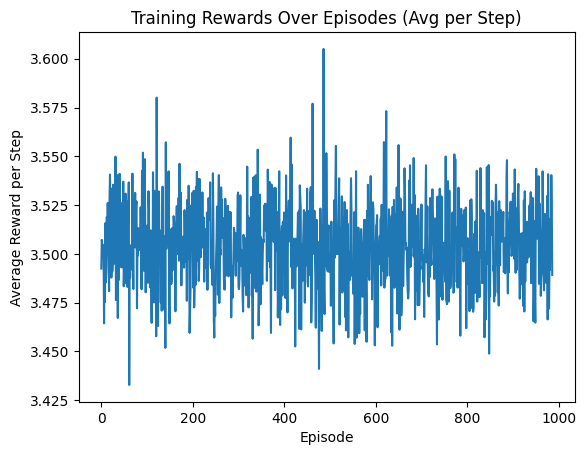


Evaluating RL Agent...
Episode 0, Step 0, State: [65.70882375 50.23965696 96.40558748]
Episode 0, Step 1, State: [49.2592167  10.08700131 80.43702763]
Episode 0, Step 2, State: [37.65928849 52.75819783 21.11243931]
Episode 0, Step 3, State: [63.68583112 71.12289341 27.52308593]
Episode 0, Step 4, State: [42.94549895 31.29542768 47.89351281]
Episode 0, Step 5, State: [56.51698879  5.03253514 22.34119473]
Episode 0, Step 6, State: [97.42180984 12.32820579 77.185019  ]
Episode 0, Step 7, State: [26.49024364 77.96907504 45.70660225]
Episode 0, Step 8, State: [74.85162061 94.80218741 67.09932124]
Episode 0, Step 9, State: [57.43668    71.81860323 18.00044938]
Episode 0, Step 10, State: [53.30454072 75.38935813 84.8450739 ]
Episode 0, Step 11, State: [89.40973998  4.10977069 44.03388498]
Episode 0, Step 12, State: [ 4.26867435 70.03574093 40.3807762 ]
Episode 0, Step 13, State: [56.27324575 34.54373987 74.46498781]
Episode 0, Step 14, State: [ 0.         45.38219647 65.18883488]
Episode 0, 

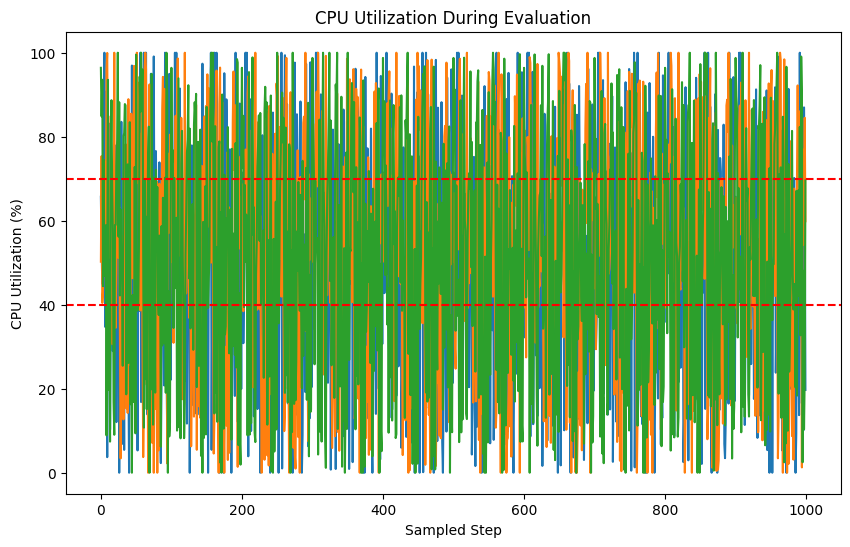


Input CPU Utilizations: EC2=30.0%, RDS=60.0%, ECS=90.0%
Predicted Actions: EC2=Scale Down (1), RDS=Scale Down (1), ECS=Scale Down (1)


In [11]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
from sklearn.metrics import mean_absolute_error, mean_squared_error
import gym
from gym import spaces
import matplotlib.pyplot as plt

# 1. Updated Environment Class
class ResourceScalingEnvCSV:
    def __init__(self, ec2_file="../reduced_ec2_data.csv", 
                 rds_file="../reduced_rds_data.csv", 
                 ecs_file="../reduced_ecs_data.csv"):
        df_ec2 = pd.read_csv(ec2_file)
        self.ec2_data = pd.to_numeric(df_ec2["EC2_CPUUtilization"], errors='coerce')
        self.ec2_data.fillna(self.ec2_data.rolling(window=20, min_periods=1).mean(), inplace=True)
        self.ec2_data = self.ec2_data.values / 100

        df_rds = pd.read_csv(rds_file)
        self.rds_data = pd.to_numeric(df_rds["RDS_CPUUtilization"], errors='coerce')
        self.rds_data.fillna(self.rds_data.rolling(window=20, min_periods=1).mean(), inplace=True)
        self.rds_data = self.rds_data.values / 100

        df_ecs = pd.read_csv(ecs_file)
        self.ecs_data = pd.to_numeric(df_ecs["ECS_CPUUtilization"], errors='coerce')
        self.ecs_data.fillna(self.ecs_data.rolling(window=20, min_periods=1).mean(), inplace=True)
        self.ecs_data = self.ecs_data.values / 100

        self.length = min(len(self.ec2_data), len(self.rds_data), len(self.ecs_data), 1000)
        self.state_size = 9  # 3 services × 3 steps
        self.action_space = spaces.MultiDiscrete([3, 3, 3])
        self.ideal = np.array([0.5, 0.5, 0.5])
        self.lower_bound = np.array([0.4, 0.4, 0.4])
        self.upper_bound = np.array([0.7, 0.7, 0.7])
        
        self.index = 0
        self.effect = np.zeros(3)
        self.history = np.zeros(self.state_size)
    
    def reset(self):
        self.index = 0
        self.effect = np.zeros(3)
        base_state = np.array([self.ec2_data[self.index], self.rds_data[self.index], self.ecs_data[self.index]])
        self.history = np.tile(np.clip(base_state + self.effect, 0, 1), 3)
        return self.history
    
    def step(self, action):
        current_state = np.clip(np.array([self.ec2_data[self.index], self.rds_data[self.index], self.ecs_data[self.index]]) + self.effect, 0, 1)
        
        new_effect = self.effect.copy()
        for i, act in enumerate(action):
            if act == 0:  # Scale Up
                diff = current_state[i] - self.ideal[i]
                diff = max(diff, 0)
                adjustment = 0.3 * diff  # Reduced to 0.3
                new_effect[i] -= adjustment
            elif act == 1:  # Scale Down
                diff = self.ideal[i] - current_state[i]
                diff = max(diff, 0)
                adjustment = 0.3 * diff
                new_effect[i] += adjustment
        self.effect = new_effect * 0.9

        self.index += 1
        done = False
        if self.index >= self.length:
            done = True
            self.index = self.length - 1

        base_state = np.array([self.ec2_data[self.index], self.rds_data[self.index], self.ecs_data[self.index]])
        next_state = np.clip(base_state + self.effect, 0, 1)
        self.history = np.concatenate((self.history[3:], next_state))
        
        error = np.mean(np.abs(next_state - self.ideal))
        threshold = 0.1
        if error <= threshold:
            base_reward = (threshold - error) * 50
        else:
            base_reward = -(error - threshold) * 12  # Increased penalty
        bonus = 2.5 if (np.all(next_state >= self.lower_bound) and np.all(next_state <= self.upper_bound)) else 0.0  # Increased bonus
        reward = base_reward + bonus + 5.0
        
        return self.history, reward, done

# 2. Define the Multi-Head DQN Network
class DQN(nn.Module):
    def __init__(self, state_size, hidden_dim=384):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.head_ec2 = nn.Linear(hidden_dim, 3)
        self.head_rds = nn.Linear(hidden_dim, 3)
        self.head_ecs = nn.Linear(hidden_dim, 3)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        q_ec2 = self.head_ec2(x)
        q_rds = self.head_rds(x)
        q_ecs = self.head_ecs(x)
        return q_ec2, q_rds, q_ecs

# 3. Define the DQN Agent
class DQNAgent:
    def __init__(self, state_size):
        self.state_size = state_size
        self.action_space = [0, 1, 2]
        self.memory = deque(maxlen=2000)
        self.gamma = 0.98
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.999995  # Slower decay
        self.learning_rate = 0.00035  # Increased learning rate
        self.model = DQN(self.state_size).float()
        self.target_model = DQN(self.state_size).float()
        self.update_target_model()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()
    
    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return np.array([random.choice(self.action_space) for _ in range(3)])
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            q_ec2, q_rds, q_ecs = self.model(state_tensor)
        action_ec2 = torch.argmax(q_ec2, dim=1).item()
        action_rds = torch.argmax(q_rds, dim=1).item()
        action_ecs = torch.argmax(q_ecs, dim=1).item()
        return np.array([action_ec2, action_rds, action_ecs])
    
    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
            q_ec2, q_rds, q_ecs = self.model(state_tensor)
            q_val = q_ec2[0, action[0]] + q_rds[0, action[1]] + q_ecs[0, action[2]]
            
            with torch.no_grad():
                next_q_ec2, next_q_rds, next_q_ecs = self.target_model(next_state_tensor)
                next_max = (torch.max(next_q_ec2, dim=1)[0] + 
                            torch.max(next_q_rds, dim=1)[0] + 
                            torch.max(next_q_ecs, dim=1)[0])
                target = reward + (self.gamma * next_max.item() * (1 - int(done)))
            
            loss = self.criterion(q_val, torch.tensor(target).float())
            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# 4. Main Training Loop
def train_rl_agent(episodes=5000):
    env = ResourceScalingEnvCSV()
    agent = DQNAgent(env.state_size)
    rewards_history = []
    best_avg_reward = float('-inf')
    patience = 500
    
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        step = 0
        done = False
        while not done and step < env.length:
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            step += 1
        agent.replay(64)
        if (episode + 1) % 25 == 0:
            agent.update_target_model()
        avg_reward = total_reward / step
        rewards_history.append(avg_reward)
        if (episode + 1) % 50 == 0:
            print(f"Episode {episode+1}/{episodes}, Avg Reward per Step: {avg_reward:.4f}, Epsilon: {agent.epsilon:.4f}")
        
        if avg_reward > best_avg_reward:
            best_avg_reward = avg_reward
            patience = 500
        else:
            patience -= 1
            if patience == 0:
                print(f"Early stopping at episode {episode+1} with best reward: {best_avg_reward:.4f}")
                break
    
    torch.save(agent.model.state_dict(), "dqn_scaling_model.pth")
    print("DQN model saved!")
    
    plt.plot(rewards_history)
    plt.title("Training Rewards Over Episodes (Avg per Step)")
    plt.xlabel("Episode")
    plt.ylabel("Average Reward per Step")
    plt.show()
    return rewards_history

# 5. Evaluate the Trained RL Agent
def evaluate_rl_agent(episodes=10):
    env = ResourceScalingEnvCSV()
    agent = DQNAgent(env.state_size)
    agent.model.load_state_dict(torch.load("dqn_scaling_model.pth"))
    agent.model.eval()
    
    total_rewards = []
    action_counts = {0: 0, 1: 0, 2: 0}
    cpu_util_history = []
    sample_rate = 10
    
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        step = 0
        done = False
        while not done and step < env.length:
            action = agent.act(state)
            next_state, reward, done = env.step(action)
            total_reward += reward
            for a in action:
                action_counts[a] += 1
            if step % sample_rate == 0:
                cpu_util_history.append(next_state[6:9] * 100)
            print(f"Episode {episode}, Step {step}, State: {next_state[6:9] * 100}")
            state = next_state
            step += 1
        avg_reward = total_reward / step
        total_rewards.append(avg_reward)
    
    overall_avg = np.mean(total_rewards)
    action_distribution = {k: v / sum(action_counts.values()) for k, v in action_counts.items()}
    
    mae = mean_absolute_error(total_rewards, np.zeros_like(total_rewards))
    mse = mean_squared_error(total_rewards, np.zeros_like(total_rewards))
    rmse = np.sqrt(mse)
    
    print(f"Average Reward per Step over evaluation episodes: {overall_avg:.4f}")
    print(f"Action Distribution: {action_distribution}")
    print(f"MAE: {mae:.4f}, MSE: {mse:.4f}, RMSE: {rmse:.4f}")
    
    cpu_util_history = np.array(cpu_util_history)
    plt.figure(figsize=(10, 6))
    plt.plot(cpu_util_history[:, 0], label="EC2 CPU")
    plt.plot(cpu_util_history[:, 1], label="RDS CPU")
    plt.plot(cpu_util_history[:, 2], label="ECS CPU")
    plt.axhline(40, color='r', linestyle='--')
    plt.axhline(70, color='r', linestyle='--')
    plt.title("CPU Utilization During Evaluation")
    plt.xlabel("Sampled Step")
    plt.ylabel("CPU Utilization (%)")
    plt.show()
    
    return overall_avg, action_distribution, mae, mse, rmse

# 6. Predict Scaling Actions
def predict_scaling_actions(cpu_utilizations):
    agent = DQNAgent(state_size=9)
    agent.model.load_state_dict(torch.load("dqn_scaling_model.pth"))
    agent.model.eval()
    agent.epsilon = 0.0
    
    state = np.tile(np.array(cpu_utilizations, dtype=np.float32), 3)
    if len(state) != 9:
        raise ValueError("Input must be normalized to 9 values (3 services × 3 steps)")
    state = np.clip(state, 0, 1)
    
    action = agent.act(state)
    action_map = {0: "Scale Up", 1: "Scale Down", 2: "No Action"}
    actions_desc = [action_map[a] for a in action]
    return action, actions_desc

if __name__ == "__main__":
    print("Training RL Agent...")
    train_rl_agent()
    print("\nEvaluating RL Agent...")
    evaluate_rl_agent()
    cpu_preds = [0.3, 0.6, 0.9]  # Example: EC2=30%, RDS=60%, ECS=90%
    action, actions_desc = predict_scaling_actions(cpu_preds)
    print(f"\nInput CPU Utilizations: EC2={cpu_preds[0]*100}%, RDS={cpu_preds[1]*100}%, ECS={cpu_preds[2]*100}%")
    print(f"Predicted Actions: EC2={actions_desc[0]} ({action[0]}), RDS={actions_desc[1]} ({action[1]}), ECS={actions_desc[2]} ({action[2]})")